# Point source sensitivity using cut-and-count

This example analysis uses the instrument response functions of the KM3NeT/ARCA detector to study the sensitivity to neutrino point sources. The effective area is convolved with a neutrino point source flux characterised by a single power law. The resulting event distribution is convolved with the detector response to obtain the expected distribution for signal events within a specified search cone. This is compared with the expected number of background events from atmospheric neutrinos and muons to calculate the sensitivity and discovery potential.

**N.B.**: The resulting sensitivity and discovery potential is worse than presented in the paper due to:
- The cut-and-count method only looks at the track (or shower) channel instead of combining both
- This analysis only includes signal from $\nu_\mu$ and $\bar{\nu}_\mu$ CC selected as track and $\nu_e$ and $\bar{\nu}_e$ CC selected as shower, instead of all flavours and interactions
- The paper uses a more sophisticated method than presented here. The paper uses a binned likelihood method and throws pseudo experiments to determine the sensitivity, while in this example we use Poisson statistics for a simple counting experiment.

In [13]:
import matplotlib.pyplot as plt

from arca230.flux import PointSourceFlux
from arca230.psf import PointSpreadFunction
from arca230.aeff import EffectiveArea
from arca230.energyresponse import EnergyResponse
from arca230.background import BackgroundComponent
from arca230.utils import create_histogram, mean_limit, nobs_disc

The flux implementation is a single power law: $\Phi^{\nu_i + \bar{\nu}_i} = \Phi_0 (E/\rm GeV)^{-\gamma}$, with $\Phi_0$ [GeV-1 s-1 m-2]

In [14]:
gamma = 2.0
norm = 5e-5  # [GeV-1 s-1 m-2]

flux_instance = PointSourceFlux(gamma=gamma, norm=norm)

Analysis input

In [15]:
livetime_1yr = 365.25 * 24 * 60 * 60  # [s]
livetime = 1 * livetime_1yr  # [s]

channel = "track"  # 'track' or 'shower'
flavor = "numu"  # 'numu' for track, 'nue' for shower

sindec = 0.475  # source location
cone = 1  # [degrees]

# statistical parameters
confidence_level = 0.9
significance = 0.0026  # p value, corresponds to 3 sigma
power = 0.5

## True neutrino energies

First we will create the distribution of neutrinos detected by the KM3NeT detector as a function of the true neutrino energy. This is done by convolving the flux model with the effective area of the detector for the given source declination.

In [16]:
aeff_instance = EffectiveArea(file_path=f"../data/aeff_coszen_all{flavor}CC_{channel}.csv")
# create the true distribution of neutrino energies
rate_trueE = aeff_instance.event_rate(flux=flux_instance, sindec=sindec, livetime=livetime)
print(f"Total signal events: { sum(rate_trueE['rate [livetime^-1]']) }")

Effective Area data loaded successfully.
Total signal events: 5.660006346621482


Plot the true neutrino energy distribution.

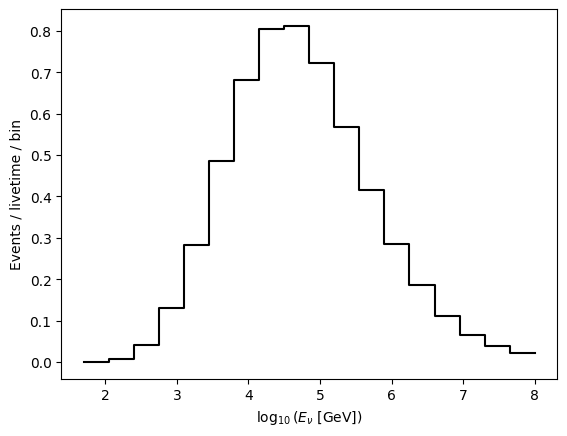

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    *create_histogram(
        rate_trueE["log10(nu_E [GeV]) low"], rate_trueE["log10(nu_E [GeV]) high"], rate_trueE["rate [livetime^-1]"]
    ),
    color="black",
    label="All events"
)
ax.set_xlabel(r"$\log_{10}(E_\nu$ [GeV])")
ax.set_ylabel("Events / livetime / bin")
plt.show()

## The point spread function

The following step is calculating how many of these events are reconstructed within the specified search cone. This is calculated using the point spread function. This function contains the event densitivty per unit solid angle $dP/d\Omega$ as a function of distance to the source $\psi$. The number of events within a search cone is calculated by integrating $dP/d\Omega$ over the cone, and normalising by the integral over $\pi$. The function depends strongly on the energy of the neutrino.

In [18]:
psf_instance = PointSpreadFunction(file_path=f"../data/psf_{flavor}CC_{channel}.csv")
rate_trueE_cone = psf_instance.event_table_within_cone(event_rate_table=rate_trueE, angle_max=cone)
print(f"Signal events within {cone} degrees: {sum(rate_trueE_cone['rate_in_cone [livetime^-1]'])}")
print(f"Fraction within {cone} degrees: {sum(rate_trueE_cone['rate_in_cone [livetime^-1]'])/sum(rate_trueE['rate [livetime^-1]'])}")

Point Spread Function data loaded successfully.
Signal events within 1 degrees: 5.0488591582768505
Fraction within 1 degrees: 0.892023586031943


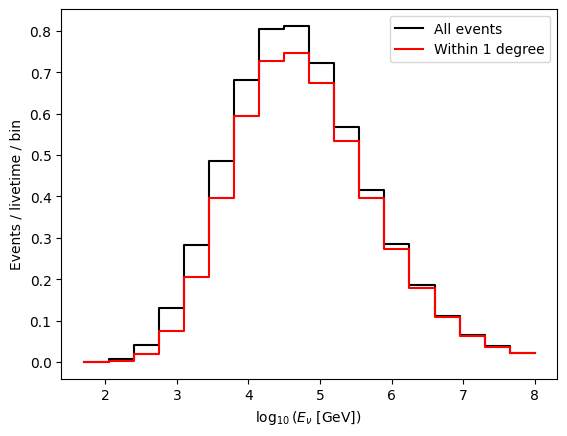

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(
    *create_histogram(
        rate_trueE_cone["log10(nu_E [GeV]) low"],
        rate_trueE_cone["log10(nu_E [GeV]) high"],
        rate_trueE_cone["rate [livetime^-1]"],
    ),
    color="black",
    label="All events",
)
ax.plot(
    *create_histogram(
        rate_trueE_cone["log10(nu_E [GeV]) low"],
        rate_trueE_cone["log10(nu_E [GeV]) high"],
        rate_trueE_cone["rate_in_cone [livetime^-1]"],
    ),
    color="red",
    label=f"Within {cone} degree",
)

ax.set_xlabel(r"$\log_{10}(E_\nu$ [GeV]) ")
ax.set_ylabel("Events / livetime / bin")
ax.legend(loc="best")

plt.show()

## Energy reconstruction and background expectation.

The final step is applying the energy reconstruction of the detector and comparing the number of expected signal events with the background rate. The background rate is the sum of all expected background events from atmospheric neutrinos and muons. It is assumed that this is an isotropic background over the full-sky, allowing us to calculate the expected background events within the search cone.

In [20]:
eres_instance = EnergyResponse(file_path=f"../data/energyresponse_{flavor}CC_{channel}.csv")
rate_recoE_cone = eres_instance.reconstruct_event_table(event_rate_table=rate_trueE_cone)

Energy response data loaded successfully.


Now let's load the expected background from atmospheric muons and neutrinos and calculate the number of events within the given search cone.

In [21]:
bkg_instance = BackgroundComponent(file_path=f"../data/bkg_{channel}.csv")
rate_bkg_cone = bkg_instance.event_rate(sindec=sindec, angle_max=cone, livetime=livetime)
print(f"Background events within {cone} degrees {sum(rate_bkg_cone['rate_in_cone [livetime^-1]'])}")

Background data loaded successfully.
Background events within 1 degrees 5.904394226015313


Let's plot!

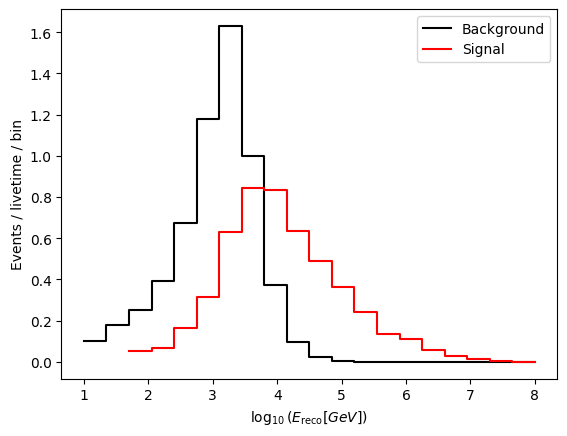

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(
    *create_histogram(
        rate_bkg_cone["log10(reco_E [GeV]) low"],
        rate_bkg_cone["log10(reco_E [GeV]) high"],
        rate_bkg_cone["rate_in_cone [livetime^-1]"],
    ),
    color="black",
    label="Background"
)

ax.plot(
    *create_histogram(
        rate_recoE_cone["log10(reco_E [GeV]) low"],
        rate_recoE_cone["log10(reco_E [GeV]) high"],
        rate_recoE_cone["rate_in_cone [livetime^-1]"],
    ),
    color="red",
    label="Signal"
)

ax.set_xlabel(r"$\log_{10}(E_{\rm reco} [GeV])$")
ax.set_ylabel("Events / livetime / bin")
ax.legend(loc="best")

plt.show()

## Statistical analysis

We now have all the ingredients to calculate the limit on the number of signal events using Poisson statistics. This limit on the number of signal events can be converted to a flux using the expected number of events from the input flux.

**N.B.:** These results are worse than presented in the paper due to the reason given at the start of this notebook.

In [23]:
# confidence level
mean_limit_nobs = mean_limit(mu0=sum(rate_bkg_cone["rate_in_cone [livetime^-1]"]), confidence_level=confidence_level)
mean_limit_flux = norm * mean_limit_nobs / sum(rate_recoE_cone["rate_in_cone [livetime^-1]"])

print(f"Mean {confidence_level} confidence level limit on the number of signal events: {mean_limit_nobs}")
print(f"Mean {confidence_level} confidence level limit on the flux: {mean_limit_flux} [Gev-1 s-1 m-2]")

Mean 0.9 confidence level limit on the number of signal events: 4.4493926898741325
Mean 0.9 confidence level limit on the flux: 4.463277294903209e-05 [Gev-1 s-1 m-2]


Similarly, we can calculate the number of signal events needed to claim discovery for the specified significance. 

In [24]:
# discovery flux
discovery_nobs = nobs_disc(mu0=sum(rate_bkg_cone["rate_in_cone [livetime^-1]"]), alpha=significance, beta=power)
discovery_flux = norm * discovery_nobs / sum(rate_recoE_cone["rate_in_cone [livetime^-1]"])

print(f"Number of events needed for a p-value {significance}: {discovery_nobs}")
print(f"Neutrino flux Phi_0 needed for p-value {significance}: {discovery_flux} [Gev-1 s-1 m-2]")

Number of events needed for a p-value 0.0026: 8.8
Neutrino flux Phi_0 needed for p-value 0.0026: 8.827460944171987e-05 [Gev-1 s-1 m-2]
